# Classification of fixed size paragraph vectors using MLP
should be able to deal with all levels using the PARTS_LEVEL param

In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple, defaultdict
import cPickle as pickle
import pandas as pd

%matplotlib inline




import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool
import multiprocessing
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from multiprocessing import Process, Queue

import seaborn

import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input, Masking
from keras.layers.convolutional import MaxPooling1D, Convolution1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.recurrent import LSTM

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *
from thesis.utils.file import *

Using Theano backend.
Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


# Global variables used throughout the script

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234
NN_SEED = 1234

In [4]:
QUEUE_SIZE = 100

In [5]:
NUM_CORES = 16

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
VALIDATION_DICT = "validation_dict.pkl"
TEST_MATRIX = "test_matrix.pkl"
TEST_DICT = "test_dict.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

TRAINING_DATA_MATRIX = "X_level_{}.npy"
TRAINING_LABELS_MATRIX = "y_{}.npy"
VALIDATION_DATA_MATRIX = "Xv_level_{}.npy"
VALIDATION_LABELS_MATRIX = "yv_{}.npy"
TEST_DATA_MATRIX = "Xt_level_{}.npy"
TEST_LABELS_MATRIX = "yt_{}.npy"

TRAINING_DATA_MATRIX_PART = "X_level_{}-{}.npy"
TRAINING_LABELS_MATRIX_PART = "y_{}-{}.npy"

In [8]:
NN_PARAMETER_SEARCH_PREFIX = "standard_nn_{}_level_{}_batch_{}_nn_parameter_searches.pkl"

In [9]:
root_location = "/mnt/data2/shalaby/"
big_data_location = "/mnt/data/shalaby/"

matrices_save_location = big_data_location + "extended_pv_matrices/"
# matrices_save_location = big_data_location + "extended_pv_matrices/one_model/"
exports_location = root_location + "exported_data/"

nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_extended_abs_desc_claims_full_chunks")

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

# Load general data required for classification

In [10]:
%%time
sections = pickle.load(open(sections_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 2.11 s, sys: 112 ms, total: 2.22 s
Wall time: 2.22 s


In [11]:
len(training_docs_list)

1286325

In [12]:
len(validation_docs_list)

321473

In [13]:
len(test_docs_list)

401877

# Utility Functions for data loading

In [14]:
data_type_file_dict ={
    "training": TRAINING_DATA_MATRIX,
    "validation": VALIDATION_DATA_MATRIX,
    "test": TEST_DATA_MATRIX,
}
labels_type_file_dict ={
    "training": TRAINING_LABELS_MATRIX,
    "validation": VALIDATION_LABELS_MATRIX,
    "test": TEST_LABELS_MATRIX,
}

def get_data_dirs(classifications_type, level, data_type):
    data_dir = os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                data_type_file_dict[data_type].format(level))
    labels_dir = os.path.join(matrices_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                labels_type_file_dict[data_type].format(classifications_type))
    return data_dir, labels_dir

def get_data(data_file, labels_file, mmap=False):
    mmap_mode = None
    if mmap == True:
        mmap_mode = "r"
    X_data = np.load(data_file, mmap_mode=mmap_mode)
    y_data = np.load(labels_file, mmap_mode=mmap_mode)
    return X_data, y_data

In [15]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallback.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallback.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallback.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallback.GRAPH_MIN, MetricsCallback.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                Xv_file, yv_file = get_data_dirs(classifications_type, PARTS_LEVEL, 'validation')
                Xv, yv = get_data(Xv_file, yv_file, mmap=True)
                yvp = self.model.predict_generator(generator=batch_generator(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE, is_mlp=True, validate=True),\
                                                   max_q_size=QUEUE_SIZE,\
                                                   val_samples=len(validation_docs_list))
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [16]:
def create_keras_nn_model(input_size, output_size, 
                          first_hidden_layer_size, first_hidden_layer_activation, 
                          second_hidden_layer_size, second_hidden_layer_activation, 
                          input_dropout_do, hidden_dropout_do, second_hidden_dropout_do=False):
    
    doc_input = Input(shape=(input_size,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(first_hidden_layer_size, activation=first_hidden_layer_activation, 
                   name='hidden_layer_{}'.format(first_hidden_layer_activation))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    if second_hidden_layer_size is not None:
        hidden = Dense(second_hidden_layer_size, activation=second_hidden_layer_activation, 
                       name='hidden_layer2_{}'.format(second_hidden_layer_activation))(hidden)
    if second_hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    softmax_output = Dense(output_size, activation='sigmoid', name='softmax_output')(hidden)

    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return model

In [17]:
class ArrayReader(Process):
    def __init__(self, input_file, label_file, out_queue, batch_size, is_mlp=False, validate=False):
        super(ArrayReader, self).__init__()
        self.is_mlp = is_mlp
        self.validate = validate
        self.q = out_queue
        self.batch_size = batch_size
        self.input_file = input_file
        self.label_file = label_file

    def run(self):
        x_file = np.load(self.input_file, mmap_mode='r')
        y_file = np.load(self.label_file, mmap_mode='r')
        start_item = 0
        num_iter = 0
#         shuffled_indices = np.arange(y_file.shape[0])
#         np.random.shuffle(shuffled_indices)
        while True:
            if start_item > y_file.shape[0]:
                info('in new epoch for {}'.format(os.path.basename(self.input_file)))
#                 np.random.seed(42 + num_iter)
#                 np.random.shuffle(shuffled_indices)
                start_item = 0
#             start_time = time.time()
            x_file[0:200000]
#             y_batch = np.copy(y_file[start_item: start_item + self.batch_size])
#             x_batch = np.copy(x_file[start_item: start_item + self.batch_size])
            y_batch = y_file[start_item: start_item + self.batch_size]
            x_batch = x_file[start_item: start_item + self.batch_size]
#             batch_indices = shuffled_indices[start_item: start_item + self.batch_size]
#             x_batch = x_file[batch_indices]
#             y_batch = y_file[batch_indices]
#             print 'Duration: {}'.format(str(time.time() - start_time))
            # because we use MLP
            if self.is_mlp:
                x_batch = np.reshape(x_batch, (x_batch.shape[0], x_batch.shape[1] * x_batch.shape[2]))
            start_item += self.batch_size
            num_iter += 1
            try:
                #print 'adding new batch'
                self.q.put((x_batch, y_batch), block=True)
            except:
                return

            
def batch_generator(input_file, label_file, batch_size, is_mlp=False, validate=False):
    q = Queue(maxsize=QUEUE_SIZE)
    p = ArrayReader(input_file, label_file, q, batch_size, is_mlp, validate)
    p.start()
    while True:
        item = q.get()
        if not item:
            p.terminate()
            info('Finished batch iteration')
            raise StopIteration()
        else:
            yield item

# Global Param Loop

In [18]:
# minimum change in val_loss from previous epoch to register as a decrease
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
# how many epochs to wait when there is no decrease in val_loss before early stopping
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
# number of epochs after which we do periodic evaluation of validation metrics
epochs_before_validation = {
    'sections': 10,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.3},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [19]:
LEVEL_DOC = 1
LEVEL_DIVISIONS = 2
LEVEL_CHUNKS = 3

In [20]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_EPOCH = 8

In [21]:
GLOBAL_PARMS_TO_RUN = [
#     {
#         'doc2vec_epoch': DOC2VEC_EPOCH,
#         'classifications': valid_classes,
#         'classifications_type': 'classes',
#         'parts_level': LEVEL_CHUNKS,
#         'nn_batch_size': 4096,
#     },
    {
        'doc2vec_epoch': DOC2VEC_EPOCH,
        'classifications': sections,
        'classifications_type': 'sections',
        'parts_level': LEVEL_CHUNKS,
        'nn_batch_size': 4096,
    }
]


==================================== NEW PARAM SET ============================================
{'classifications_type': 'sections', 'parts_level': 3, 'doc2vec_epoch': 8, 'nn_batch_size': 4096}
doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


2017-04-15 18:55:20,608 : INFO : No Previous results exist in /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_full_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/standard_nn_sections_level_3_batch_4096_nn_parameter_searches.pkl
2017-04-15 18:55:20,610 : INFO : ***************************************************************************************
2017-04-15 18:55:20,611 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          6801000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 500)           500500      dropout_1[0][0]                  
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


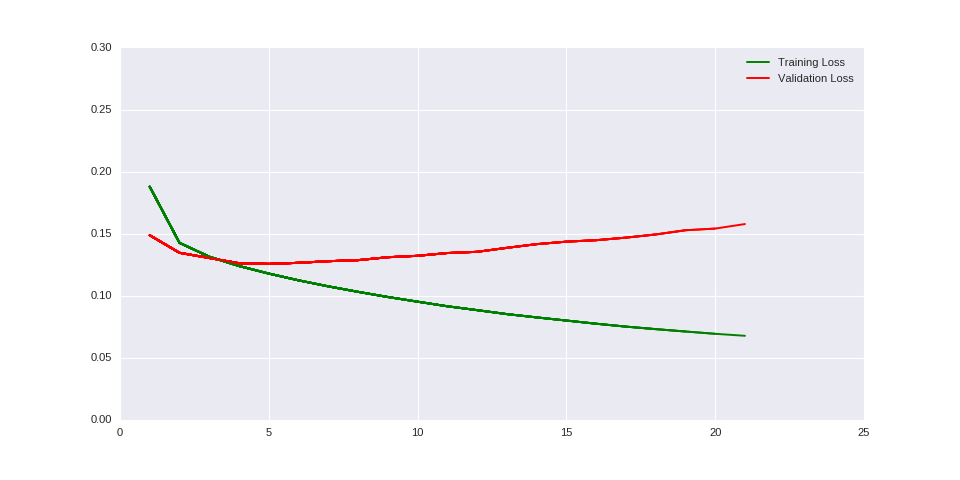

Epoch 1/200
 876544/1286325 [===================>..........] - ETA: 23s - loss: 0.2019

2017-04-15 18:56:12,674 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1881

2017-04-15 18:56:36,293 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy
2017-04-15 18:57:11,648 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy
2017-04-15 18:57:34,004 : INFO : Found lower val loss for epoch 1 => 0.14898


    
1286325/1286325 [==============================] - 131s - loss: 0.1881 - val_loss: 0.1490
Epoch 2/200
 753664/1286325 [================>.............] - ETA: 28s - loss: 0.1451

2017-04-15 18:58:14,375 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1428

2017-04-15 18:59:15,939 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy
2017-04-15 18:59:45,257 : INFO : Found lower val loss for epoch 2 => 0.13484


    
1286325/1286325 [==============================] - 131s - loss: 0.1428 - val_loss: 0.1348
Epoch 3/200
 876544/1286325 [===================>..........] - ETA: 17s - loss: 0.1310

2017-04-15 19:00:22,651 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1317

2017-04-15 19:01:17,442 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy
2017-04-15 19:01:44,847 : INFO : Found lower val loss for epoch 3 => 0.13064


    
1286325/1286325 [==============================] - 119s - loss: 0.1317 - val_loss: 0.1306
Epoch 4/200
 823296/1286325 [==================>...........] - ETA: 21s - loss: 0.1228

2017-04-15 19:02:22,339 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1242

2017-04-15 19:03:16,389 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy
2017-04-15 19:03:44,131 : INFO : Found lower val loss for epoch 4 => 0.12645


    
1286325/1286325 [==============================] - 119s - loss: 0.1242 - val_loss: 0.1265
Epoch 5/200
 823296/1286325 [==================>...........] - ETA: 21s - loss: 0.1159

2017-04-15 19:04:22,276 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1181

2017-04-15 19:05:23,421 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy
2017-04-15 19:05:50,624 : INFO : Found lower val loss for epoch 5 => 0.12588


    
1286325/1286325 [==============================] - 126s - loss: 0.1181 - val_loss: 0.1259
Epoch 6/200
 876544/1286325 [===================>..........] - ETA: 30s - loss: 0.1092

2017-04-15 19:06:55,152 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1126

2017-04-15 19:08:03,685 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 163s - loss: 0.1126 - val_loss: 0.1268
Epoch 7/200
 880640/1286325 [===================>..........] - ETA: 20s - loss: 0.1036

2017-04-15 19:09:18,799 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1078

2017-04-15 19:11:09,900 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 200s - loss: 0.1078 - val_loss: 0.1281
Epoch 8/200
 876544/1286325 [===================>..........] - ETA: 20s - loss: 0.0985

2017-04-15 19:12:38,892 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.1034

2017-04-15 19:14:08,743 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 168s - loss: 0.1034 - val_loss: 0.1289
Epoch 9/200
 876544/1286325 [===================>..........] - ETA: 22s - loss: 0.0936

2017-04-15 19:15:31,261 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0992

2017-04-15 19:17:07,155 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 178s - loss: 0.0992 - val_loss: 0.1313
Epoch 10/200
 876544/1286325 [===================>..........] - ETA: 21s - loss: 0.0893

2017-04-15 19:18:27,865 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0954

2017-04-15 19:19:19,960 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 132s - loss: 0.0954 - val_loss: 0.1324
Epoch 11/200
 876544/1286325 [===================>..........] - ETA: 21s - loss: 0.0851

2017-04-15 19:20:40,859 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0917

2017-04-15 19:21:43,273 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 144s - loss: 0.0917 - val_loss: 0.1347
Epoch 12/200
 876544/1286325 [===================>..........] - ETA: 21s - loss: 0.0815

2017-04-15 19:23:04,302 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0886

2017-04-15 19:24:06,627 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 144s - loss: 0.0886 - val_loss: 0.1356
Epoch 13/200
 876544/1286325 [===================>..........] - ETA: 22s - loss: 0.0779

2017-04-15 19:25:31,176 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0854

2017-04-15 19:26:31,407 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 146s - loss: 0.0854 - val_loss: 0.1388
Epoch 14/200
 876544/1286325 [===================>..........] - ETA: 21s - loss: 0.0749

2017-04-15 19:27:55,143 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0827

2017-04-15 19:28:51,664 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 142s - loss: 0.0827 - val_loss: 0.1418
Epoch 15/200
 876544/1286325 [===================>..........] - ETA: 21s - loss: 0.0721

2017-04-15 19:30:18,194 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0802

2017-04-15 19:31:20,356 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 149s - loss: 0.0802 - val_loss: 0.1438
Epoch 16/200
 876544/1286325 [===================>..........] - ETA: 21s - loss: 0.0692

2017-04-15 19:32:46,356 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0777

2017-04-15 19:33:44,317 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 145s - loss: 0.0776 - val_loss: 0.1450
Epoch 17/200
 876544/1286325 [===================>..........] - ETA: 21s - loss: 0.0665

2017-04-15 19:35:12,604 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0753

2017-04-15 19:36:10,536 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 145s - loss: 0.0753 - val_loss: 0.1471
Epoch 18/200
 876544/1286325 [===================>..........] - ETA: 22s - loss: 0.0644

2017-04-15 19:37:38,443 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0733

2017-04-15 19:38:35,588 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 147s - loss: 0.0733 - val_loss: 0.1496
Epoch 19/200
 876544/1286325 [===================>..........] - ETA: 22s - loss: 0.0623

2017-04-15 19:40:07,810 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0714

2017-04-15 19:41:03,019 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 149s - loss: 0.0714 - val_loss: 0.1530
Epoch 20/200
  20480/1286325 [..............................] - ETA: 88s - loss: 0.0643

/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/keras/callbacks.py:119: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120293). Check your callbacks.
  % delta_t_median)


 876544/1286325 [===================>..........] - ETA: 21s - loss: 0.0603

2017-04-15 19:42:35,314 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0695

2017-04-15 19:43:30,775 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 148s - loss: 0.0695 - val_loss: 0.1544
Epoch 21/200
 876544/1286325 [===================>..........] - ETA: 22s - loss: 0.0587

2017-04-15 19:45:04,926 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/X_level_3.npy


1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0679

2017-04-15 19:45:58,268 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy


1286325/1286325 [==============================] - 148s - loss: 0.0679 - val_loss: 0.1580


2017-04-15 19:46:45,642 : INFO : Evaluating on Validation Data using saved best weights


Epoch 00020: early stopping
CPU times: user 12min 4s, sys: 46min 17s, total: 58min 21s
Wall time: 51min 24s


2017-04-15 19:46:46,112 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy
2017-04-15 19:46:59,558 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xv_level_3.npy
2017-04-15 19:47:05,253 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.376 | Top 3: 0.979 | Top 5: 0.997 | F1 Micro: 0.818 | F1 Macro: 0.770


In [22]:
%matplotlib notebook

for GLOBAL_PARAMS in GLOBAL_PARMS_TO_RUN:
    
    print '==================================== NEW PARAM SET ============================================'
    print {k:v for k,v in GLOBAL_PARAMS.items() if k != 'classifications'}
    
    classifications = GLOBAL_PARAMS['classifications']
    classifications_type = GLOBAL_PARAMS['classifications_type']
    
    PARTS_LEVEL = GLOBAL_PARAMS['parts_level']
    
    placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
    GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
    placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

    epoch = GLOBAL_PARAMS['doc2vec_epoch']

    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    print GLOBAL_VARS.MODEL_NAME
    
    time.sleep(0.2)
    
    X_file, y_file = get_data_dirs(classifications_type, PARTS_LEVEL, 'training')
    Xv_file, yv_file = get_data_dirs(classifications_type, PARTS_LEVEL, 'validation')
    X, y = get_data(X_file, y_file, mmap=True)
    
#     X,y = get_training_data_mmap(classifications_type, PARTS_LEVEL)
    
    NN_INPUT_NEURONS = X.shape[1] * X.shape[2]
    NN_OUTPUT_NEURONS = len(classifications)
    
    EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
    EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

    NN_MAX_EPOCHS = 200
    NN_PARAM_SAMPLE_SEED = 1234

    NN_BATCH_SIZE = GLOBAL_PARAMS['nn_batch_size']

    MODEL_VERBOSITY = 1

    NN_OPTIMIZER = 'rmsprop'
    # NN_OPTIMIZER = 'adam'

    to_skip = []

    load_existing_results = True
    save_results = True


    first_hidden_layer_sizes = [100,200,500,1000]
    second_hidden_layer_sizes = [None,500,1000,2000]
    first_hidden_layer_activations = ['relu','sigmoid', 'tanh']
    second_hidden_layer_activations = ['relu','sigmoid', 'tanh']
    # first_hidden_layer_activations = ['relu']
    # second_hidden_layer_activations = ['relu']
    # input_dropout_options = [False, True]
    # hidden_dropout_options = [False, True]
    input_dropout_options = [False]
    hidden_dropout_options = [True]
    second_hidden_dropout_options = [False]

    
    first_hidden_layer_sizes = [1000]
    second_hidden_layer_sizes = [500,]
    first_hidden_layer_activations = ['sigmoid']
    second_hidden_layer_activations = ['relu']
    # first_hidden_layer_activations = ['relu']
    # second_hidden_layer_activations = ['relu']
    # input_dropout_options = [False, True]
    # hidden_dropout_options = [False, True]
    input_dropout_options = [False]
    hidden_dropout_options = [True]
    second_hidden_dropout_options = [False]
    NN_RANDOM_SEARCH_BUDGET = 1


    np.random.seed(NN_SEED)
    
    
    ################################################################################
    ############### Actual Training


    # load previous finshed results so we dont redo them
    param_results_dict = {}

    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))

    if load_existing_results:
        if os.path.exists(param_results_path):
            info('Loading Previous results in {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))

    ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
    
    param_sampler = ParameterSampler({
        'first_hidden_layer_size':first_hidden_layer_sizes,
        'first_hidden_layer_activation':first_hidden_layer_activations,
        'second_hidden_layer_size':second_hidden_layer_sizes,
        'second_hidden_layer_activation':second_hidden_layer_activations,
        'input_dropout':input_dropout_options,
        'hidden_dropout':hidden_dropout_options,
        'second_hidden_dropout':second_hidden_dropout_options
    }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)


    for parameters in param_sampler:
        start_time = time.time()
        first_hidden_layer_size = parameters['first_hidden_layer_size']
        first_hidden_layer_activation = parameters['first_hidden_layer_activation']
        second_hidden_layer_size = parameters['second_hidden_layer_size']
        second_hidden_layer_activation = parameters['second_hidden_layer_activation']
        input_dropout_do = parameters['input_dropout']
        hidden_dropout_do = parameters['hidden_dropout']
        second_hidden_dropout_do = parameters['second_hidden_dropout']

        GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
            first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
            second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
        )
        if second_hidden_dropout_do:
            GLOBAL_VARS.NN_MODEL_NAME = GLOBAL_VARS.NN_MODEL_NAME + '_2nd-hid-drop_{}'.format(str(second_hidden_dropout_do))

        if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
            print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
            continue
            

        info('***************************************************************************************')
        info(GLOBAL_VARS.NN_MODEL_NAME)

        
        model = create_keras_nn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                                      first_hidden_layer_size, first_hidden_layer_activation, 
                                      second_hidden_layer_size, second_hidden_layer_activation, 
                                      input_dropout_do, hidden_dropout_do, second_hidden_dropout_do)
        model.summary()

        early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA,
                                                      patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
        metrics_callback = MetricsCallback()


        # Model Fitting
        %time history = model.fit_generator(generator=batch_generator(X_file, y_file, NN_BATCH_SIZE, is_mlp=True, validate=False),\
                                            validation_data=batch_generator(Xv_file, yv_file, NN_BATCH_SIZE, is_mlp=True, validate=True),\
                                            samples_per_epoch=len(training_docs_list), \
                                            nb_val_samples=len(validation_docs_list),\
                                            nb_epoch=NN_MAX_EPOCHS,\
                                            callbacks=[early_stopper, metrics_callback],\
                                            max_q_size=QUEUE_SIZE)
                                            #validation_data=(Xv,yv), 

    

        # using the recorded weights of the best recorded validation loss
        last_model_weights = model.get_weights()
        info('Evaluating on Validation Data using saved best weights')
        model.set_weights(metrics_callback.best_weights)
        yvp = model.predict_generator(generator=batch_generator(Xv_file, yv_file, NN_BATCH_SIZE, is_mlp=True, validate=True),\
                                       max_q_size=QUEUE_SIZE,\
                                       val_samples=len(validation_docs_list))
        yvp_binary = get_binary_0_5(yvp)
        Xv, yv = get_data(Xv_file, yv_file, mmap=True)
        #print yvp
        info('Generating Validation Metrics')
        validation_metrics = get_metrics(yv, yvp, yvp_binary)
        print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
            validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
            validation_metrics['f1_micro'], validation_metrics['f1_macro'])
        best_validation_metrics = validation_metrics
        
        time.sleep(0.2)
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

        duration = time.time() - start_time
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

        del history, last_model_weights, metrics_callback
        
        for p in multiprocessing.active_children():
            # closing the array readers
            p.terminate()

    if save_results:
        if load_existing_results:
            if os.path.exists(param_results_path):
                info('Loading Previous results from {}'.format(param_results_path))
                loaded_param_results_dict = pickle.load(open(param_results_path))
                param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(param_results_path, 'w'))
        

In [26]:
Xv, yv = get_validation_data_mmap(classifications_type, PARTS_LEVEL)
#print yvp
info('Generating Validation Metrics')
validation_metrics = get_metrics(yv, yvp, yvp_binary)
print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
best_validation_metrics = validation_metrics

time.sleep(0.2)
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

duration = time.time() - start_time
param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

del history, last_model_weights, metrics_callback

if save_results:
    if load_existing_results:
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            loaded_param_results_dict = pickle.load(open(param_results_path))
            param_results_dict.update(loaded_param_results_dict)

    pickle.dump(param_results_dict, open(param_results_path, 'w'))


2017-04-15 03:55:37,925 : INFO : Loading Validation Data from file using mmap
2017-04-15 03:55:37,995 : INFO : Finished Loading Validation Data from file using mmap
2017-04-15 03:55:37,996 : INFO : Generating Validation Metrics
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted',

****** Validation Metrics: Cov Err: 5.945 | Top 3: 0.764 | Top 5: 0.843 | F1 Micro: 0.574 | F1 Macro: 0.181


## Testing

In [45]:
classifications = valid_subclasses
classifications_type = 'subclasses'

In [46]:
TEST_METRICS_FILENAME = '{}_level_{}_standard_nn_test_metrics.pkl'

In [47]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                            DOC2VEC_WINDOW, 
                                                            'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                            DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                            DOC2VEC_TRAIN_WORDS,
                                                            DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                            str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = DOC2VEC_EPOCH

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
print GLOBAL_VARS.MODEL_NAME

doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


In [48]:
NN_BATCH_SIZE = 4096

In [49]:
PARTS_LEVEL = 3

In [50]:
param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
param_results_dict = pickle.load(open(param_results_path))

In [51]:
Xt_file, yt_file = get_data_dirs(classifications_type, PARTS_LEVEL, 'test')
Xt, yt = get_data(Xt_file, yt_file, mmap=True)

In [52]:
info("Reshaping")
Xt = np.reshape(Xt, (Xt.shape[0], Xt.shape[1]* Xt.shape[2]))
print Xt.shape

2017-04-15 20:56:07,114 : INFO : Reshaping


(401877, 6800)


In [53]:
NN_OUTPUT_NEURONS = len(classifications)
NN_INPUT_NEURONS = Xt.shape[1]

In [54]:
param_results_dict.keys()

['nn_1st-size_1000_1st-act_sigmoid_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True']

In [55]:
first_hidden_layer_size = 1000
first_hidden_layer_activation = 'sigmoid'
second_hidden_layer_size = 500
second_hidden_layer_activation = 'relu'
input_dropout_do = False
hidden_dropout_do = True
second_hidden_dropout_do = False

GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
    first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
    second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
)
if second_hidden_dropout_do:
    GLOBAL_VARS.NN_MODEL_NAME = GLOBAL_VARS.NN_MODEL_NAME + '_2nd-hid-drop_{}'.format(str(second_hidden_dropout_do))

if GLOBAL_VARS.NN_MODEL_NAME not in param_results_dict.keys():
    print "Can't find model: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
    raise Exception()

    
info('***************************************************************************************')
info(GLOBAL_VARS.NN_MODEL_NAME)

model = create_keras_nn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                              first_hidden_layer_size, first_hidden_layer_activation, 
                              second_hidden_layer_size, second_hidden_layer_activation, 
                              input_dropout_do, hidden_dropout_do)
model.summary()

# get model best weights
# weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['metrics_callback'].best_weights
weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights']
model.set_weights(weights)

info('Evaluating on Test Data using best weights')
ytp = model.predict_generator(generator=batch_generator(Xt_file, yt_file, NN_BATCH_SIZE, is_mlp=True, validate=True),\
                                       max_q_size=QUEUE_SIZE,\
                                       val_samples=len(test_docs_list))
ytp_binary = get_binary_0_5(ytp)
#print yvp
info('Generating Test Metrics')
test_metrics = get_metrics(yt, ytp, ytp_binary)
print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
    test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
    test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])

ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
    
pickle.dump(test_metrics, open(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                            TEST_METRICS_FILENAME.format(classifications_type, PARTS_LEVEL)), 'w'))


2017-04-15 20:56:07,187 : INFO : ***************************************************************************************
2017-04-15 20:56:07,188 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True
2017-04-15 20:56:07,608 : INFO : Evaluating on Test Data using best weights


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 6800)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          6801000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_4 (Dropout)              (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 500)           500500      dropout_4[0][0]                  
___________________________________________________________________________________________

2017-04-15 20:56:08,473 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xt_level_3.npy
2017-04-15 20:57:24,534 : INFO : in new epoch for /mnt/data/shalaby/extended_pv_matrices/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/Xt_level_3.npy
2017-04-15 20:58:42,256 : INFO : Generating Test Metrics


** Test Metrics: Cov Err: 5.728, Avg Labels: 1.340, 
		 Top 1: 0.635, Top 3: 0.775, Top 5: 0.852, 
		 F1 Micro: 0.590, F1 Macro: 0.206, Total Pos: 378,343


## Test batching

In [22]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                            DOC2VEC_WINDOW, 
                                                            'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                            DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                            DOC2VEC_TRAIN_WORDS,
                                                            DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                            str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = 8

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)

In [23]:
classifications_type = 'sections'
level = 3
batch_size = 2048
is_mlp, validate = False, False

In [57]:
q = Queue(maxsize=10)
p = ArrayReader(classifications_type, level, q, batch_size, is_mlp, validate)

In [58]:
p.run()

2017-04-14 23:56:48,393 : INFO : Loading Training Data from file using mmap
2017-04-14 23:56:48,398 : INFO : Finished Loading Training Data from file using mmap


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 159 µs
CPU times: user 12 ms, sys: 24 ms, total: 36 ms
Wall time: 38.1 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 205 µs
CPU times: user 28 ms, sys: 8 ms, total: 36 ms
Wall time: 37.2 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 115 µs
CPU times: user 12 ms, sys: 24 ms, total: 36 ms
Wall time: 36.9 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 345 µs
CPU times: user 16 ms, sys: 16 ms, total: 32 ms
Wall time: 33.4 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 422 µs
CPU times: user 12 ms, sys: 20 ms, total: 32 ms
Wall time: 29.4 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 121 µs
CPU times: user 4 ms, sys: 24 ms, total: 28 ms
Wall time: 26.6 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 159 µs
CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 25.4 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 67 µs
CPU times: user 12 ms, sys: 12 

## Test batching

In [22]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_EPOCH = 8

In [23]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                            DOC2VEC_WINDOW, 
                                                            'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                            DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                            DOC2VEC_TRAIN_WORDS,
                                                            DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                            str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = 8

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)

In [24]:
classifications_type = 'sections'
level = 3
batch_size = 2048
is_mlp, validate = True, False

In [58]:

# class ArrayReader(Process):
class ArrayReader():
    def __init__(self, classifications_type, level, out_queue, batch_size, is_mlp=False, validate=False):
#         super(ArrayReader, self).__init__()
        self.is_mlp = is_mlp
        self.validate = validate
        self.q = out_queue
        self.batch_size = batch_size
        self.classifications_type = classifications_type
        self.level = level

    def run(self):
        x_file, y_file = get_training_data_mmap(self.classifications_type, self.level) 
        start_item = 0
        num_iter = 0
        shuffled_indices = np.arange(y_file.shape[0])
        while True:
            if start_item > y_file.shape[0]:
                print 'new epoch'
                start_item = 0
#             y_batch = np.copy(y_file[start_item: start_item + self.batch_size])
#             x_batch = np.copy(x_file[start_item: start_item + self.batch_size])
            batch_indices = shuffled_indices[start_item: start_item + self.batch_size]
            print x_file.shape
            y_batch = y_file[batch_indices]
            x_batch = x_file[batch_indices]
            print y_batch.shape
            print x_batch.shape
            # because we use MLP
            if self.is_mlp:
                x_batch = np.reshape(x_batch, (x_batch.shape[0], x_batch.shape[1] * x_batch.shape[2]))
            start_item += self.batch_size
            num_iter += 1
            self.q.put((x_batch, y_batch), block=True)
            
def batch_generator(classifications_type, level, batch_size, is_mlp=False, validate=False):
    q = Queue(maxsize=10)
    p = ArrayReader(classifications_type, level, q, batch_size, is_mlp, validate)
    p.start()
    while True:
        item = q.get()
        if not item:
            p.terminate()
            raise StopIteration()
        else:
            yield item

In [48]:
class ArrayReader(Process):
    def __init__(self, classifications_type, level, out_queue, batch_size, is_mlp=False, validate=False):
        super(ArrayReader, self).__init__()
        self.is_mlp = is_mlp
        self.validate = validate
        self.q = out_queue
        self.batch_size = batch_size
        self.classifications_type = classifications_type
        self.level = level

    def run(self):
        if not self.validate:
            x_file, y_file = get_training_data_mmap(self.classifications_type, self.level)
        else:
            x_file, y_file = get_validation_data_mmap(self.classifications_type, self.level)
        start_item = 0
        num_iter = 0
        shuffled_indices = np.arange(y_file.shape[0])
#         np.random.shuffle(shuffled_indices)
        while True:
            if start_item > y_file.shape[0]:
                print 'in new epoch'
#                 np.random.seed(42 + num_iter)
#                 np.random.shuffle(shuffled_indices)
                start_item = 0
#             y_batch = np.copy(y_file[start_item: start_item + self.batch_size])
#             x_batch = np.copy(x_file[start_item: start_item + self.batch_size])
            batch_indices = shuffled_indices[start_item: start_item + self.batch_size]
            x_batch, y_array = np.zeros((1,1)), np.zeros((1,1))
            start_time = time.time()
            x_batch = np.copy(x_file[batch_indices])
            y_batch = np.copy(y_file[batch_indices])
            print 'Duration: {}'.format(str(time.time() - start_time))
            # because we use MLP
            if self.is_mlp:
                x_batch = np.reshape(x_batch, (x_batch.shape[0], x_batch.shape[1] * x_batch.shape[2]))
            start_item += self.batch_size
            num_iter += 1
            try:
                print 'adding new batch'
                self.q.put((x_batch, y_batch), block=True)
            except:
                return

In [49]:
q = Queue(maxsize=100)
p = ArrayReader(classifications_type, level, q, batch_size, is_mlp, validate)

In [50]:
p.run()

2017-04-15 03:26:42,036 : INFO : Loading Training Data from file using mmap
2017-04-15 03:26:42,040 : INFO : Finished Loading Training Data from file using mmap


Duration: 0.0615739822388
adding new batch
Duration: 0.188284873962
adding new batch
Duration: 0.0573651790619
adding new batch
Duration: 0.0536658763885
adding new batch
Duration: 0.163289070129
adding new batch
Duration: 0.162258863449
adding new batch
Duration: 0.159317970276
adding new batch
Duration: 0.157483100891
adding new batch
Duration: 0.153153896332
adding new batch
Duration: 0.153907060623
adding new batch
Duration: 0.132169961929
adding new batch
Duration: 0.134433031082
adding new batch
Duration: 0.182116985321
adding new batch
Duration: 0.154788970947
adding new batch
Duration: 0.149490833282
adding new batch
Duration: 0.156996011734
adding new batch
Duration: 0.144598007202
adding new batch
Duration: 0.212677001953
adding new batch
Duration: 0.115936040878
adding new batch
Duration: 0.202229976654
adding new batch
Duration: 0.174211978912
adding new batch
Duration: 0.15162396431
adding new batch
Duration: 0.146477937698
adding new batch
Duration: 0.0841519832611
adding

KeyboardInterrupt: 

In [33]:
p.terminate()

AttributeError: 'NoneType' object has no attribute 'terminate'

In [26]:
p.start()

2017-04-15 03:14:23,156 : INFO : Loading Training Data from file using mmap
2017-04-15 03:14:23,162 : INFO : Finished Loading Training Data from file using mmap


In [27]:
p.terminate()

## Terminate children

In [ ]:
for p in multiprocessing.active_children():
    # closing the array readers
    p.terminate()